Universidade Federal de Alagoas

IC - Instituto de Computação

 

# Processamento de linguagem natural - 2020.1
**Professor**: Thales Vieira

**Alunos**: Hugo Tallys Martins Oliveira e Valério Nogueira Rodrigues Júnior


## 2ª lista de exercícios

---

# Descrição dos dados

Os textos que constituem o conjunto de dados (1616 artigos de notícia) foram extraídos do site da BBC Brasil e CNN Brasil. Os links para os artigos foram obtidos na página de busca do site com o termo de pesquisa "coronavírus" (dados coletados em 13/06/2020 para o site da BBC e em 14/06/2020 para o site da CNN):

> https://www.bbc.com/portuguese/search?q=coronav%C3%ADrus

> https://www.cnnbrasil.com.br/search?q=coronav%C3%ADrus

Para construir o _dataframe_ extraímos as seguintes informações do arquivo `html` de cada página:

* title - Título da notícia (tag \<title\>\</title\>)
* text - Texto de cada parágrafo da notícia (tags \<p\>\</p\>) concatenados

In [ ]:
import re
import nltk
import numpy
import pandas
import pickle
import seaborn

from random import shuffle
from matplotlib import pyplot
from string import punctuation

%matplotlib inline

In [ ]:

nltk.download('stopwords');
nltk.download('rslp');
nltk.download('punkt');
nltk.download('averaged_perceptron_tagger');
nltk.download('mac_morpho');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


In [ ]:
bbc_dataset_url = 'https://raw.githubusercontent.com/valeriojr/ecom063-pln/master/data/bbc.csv'
cnn_dataset_url = 'https://raw.githubusercontent.com/valeriojr/ecom063-pln/master/data/cnn.csv'

dataset = pandas.concat([pandas.read_csv(dataset_url, sep='|') for dataset_url in [bbc_dataset_url, cnn_dataset_url]], ignore_index=True)
dataset = dataset.dropna(axis=0).reset_index(drop=True)
dataset

,url,title,text
0,https://www.bbc.co.uk/portuguese/brasil-53020785,"Coronavírus: pandemia pode jogar até 14 milhões de brasileiros na pobreza, diz estudo - BBC News Brasil",\nCompartilhe este post com\nEmail\nFacebook\nMessenger\nMessenger\nTwitter\nWhatsApp\nLinkedIn\nCopiar este link\nEstes são links externos e abri...
1,https://www.bbc.co.uk/portuguese/brasil-53027318,Coronavírus: como funcionam as duas vacinas contra covid-19 que serão testadas em brasileiros - BBC News Brasil,\nCompartilhe este post com\nEmail\nFacebook\nMessenger\nMessenger\nTwitter\nWhatsApp\nLinkedIn\nCopiar este link\nEstes são links externos e abri...
2,https://www.bbc.co.uk/portuguese/brasil-51713943,Coronavírus: Brasil passa o Reino Unido e se torna segundo país com mais mortes por covid-19 - BBC News Brasil,\nCompartilhe este post com\nEmail\nFacebook\nMessenger\nMessenger\nTwitter\nWhatsApp\nLinkedIn\nCopiar este link\nEstes são links externos e abri...
3,https://www.bbc.co.uk/portuguese/internacional-53008262,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil",\nCompartilhe este post com\nEmail\nFacebook\nMessenger\nMessenger\nTwitter\nWhatsApp\nLinkedIn\nCopiar este link\nEstes são links externos e abri...
4,https://www.bbc.co.uk/portuguese/internacional-53008266,"2ª onda do coronavírus? Irã vê aumento acelerado após reabertura, mas cita testes como causa - BBC News Brasil",\nCompartilhe este post com\nEmail\nFacebook\nMessenger\nMessenger\nTwitter\nWhatsApp\nLinkedIn\nCopiar este link\nEstes são links externos e abri...
...,...,...,...
1611,https://www.cnnbrasil.com.br/saude/2020/02/27/farmacias-tem-falta-de-mascaras-apos-confirmacao-de-coronavirus-no-brasil,Farmácias têm falta de máscaras após confirmação de coronavírus no Brasil,"Com a confirmação do primeiro caso de contaminação pelo novo coronavírus (Covid-19) no Brasil na quarta-feira (26), as farmácias no país registrar..."
1612,https://www.cnnbrasil.com.br/business/2020/02/27/ibovespa-tem-nova-queda-com-mercado-ainda-preocupado-sobre-coronavirus,Ibovespa tem nova queda com mercado ainda preocupado com coronavírus,Preocupações com a propagação do novo coronavírus e seus potenciais efeitos na economia global mantiveram a bolsa de valores de São Paulo pression...
1613,https://www.cnnbrasil.com.br/internacional/2020/02/27/japonesa-testa-positivo-pela-2-vez-para-coronavirus,Japonesa testa positivo pela segunda vez para coronavírus,"TÓQUIO - Uma guia de ônibus turístico no Japão apresentou resultado positivo, pela segunda vez, para o novo coronavírus, se tornando a primeira pe..."
1614,https://www.cnnbrasil.com.br/saude/2020/02/26/paciente-com-coronavirus-tem-sintomas-brandos-mas-continua-isolado,"Primeiro brasileiro com coronavírus tem sintomas brandos, mas continua isolado","O primeiro brasileiro com diagnóstico confirmado de coronavírus apresenta sintomas brandos, mas continua isolado em casa, informou nesta quarta-..."


Observando um exemplo do conjunto de dados com mais detalhe:

In [ ]:
row = dataset.iloc[478]
print('Url: ', row.url)
print('Título: ', row.title)
print('Texto: ', row.text)

Url:  https://www.cnnbrasil.com.br/internacional/2020/05/03/nova-onda-do-coronavirus-pode-atingir-eua-no-outono-mas-ha-como-para-la
Título:  Nova 'onda' do coronavírus pode atingir EUA no outono, mas há como pará-la
Texto:  A pandemia do novo coronavírus pode estar se tornando mais lenta em várias partes dos Estados Unidos por causa dos esforços de distanciamento social mas ainda não planeje suas festas, férias ou idas ao escritório ainda. Especialistas dizem que o vírus não será coisa do passado tão cedo.  Uma segunda onda de casos da COVID-19 no outono é “inevitável”, disse Anthony Fauci, principal infectologista americano, à medida em que as pessoas tentam de forma crescente retomar a vida normal, e muitos estados flexibilizam ou revogam suas ordens de ficar em casa.  “Eu estou quase certo de que vai voltar, porque o vírus é tão transmissível e tão disperso no mundo todo”, disse Fauci durante uma conferência online com o Clube Econômico de Washington nesta semana.  Os americanos pod

# Higienização dos dados


1. Remoção de quebras de linha

In [ ]:
dataset.text = dataset.text.apply(lambda text: text.replace('\n', ' '))

2. Remoção de partes da página que não interessam

In [ ]:
def remove_boilerplate(text):
    boilerplate = ['Compartilhe este post com Email Facebook Messenger Messenger Twitter WhatsApp LinkedIn Copiar este link Estes são links externos e abrirão numa nova janela', 'Já assistiu aos nossos novos vídeos no YouTube? Inscreva-se no nosso canal!', 'Final de YouTube post  de BBC News Brasil Final de YouTube post 2 de BBC News Brasil Final de YouTube post 3 de BBC News Brasil']
    
    for b in boilerplate:
      text = text.replace(b, '')

    return text

dataset.text = dataset.text.apply(remove_boilerplate)

In [ ]:
dataset.head()

,url,title,text
0,https://www.bbc.co.uk/portuguese/brasil-53020785,"Coronavírus: pandemia pode jogar até 14 milhões de brasileiros na pobreza, diz estudo - BBC News Brasil","A turbulência econômica causada pela pandemia do novo coronavírus pode jogar até 14,4 milhões de brasileiros na pobreza, segundo um novo estudo ..."
1,https://www.bbc.co.uk/portuguese/brasil-53027318,Coronavírus: como funcionam as duas vacinas contra covid-19 que serão testadas em brasileiros - BBC News Brasil,Cerca de 11 mil voluntários brasileiros vão receber nas próximas semanas duas vacinas diferentes contra o coronavírus que estão em fase avançada...
2,https://www.bbc.co.uk/portuguese/brasil-51713943,Coronavírus: Brasil passa o Reino Unido e se torna segundo país com mais mortes por covid-19 - BBC News Brasil,"*atualizada às 18h20 de 12 de junho de 2020 O Brasil totalizou, nesta sexta-feira (12), 41.828 mortes por covid-19 desde a chegada do novo coron..."
3,https://www.bbc.co.uk/portuguese/internacional-53008262,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil","Quando, em 24 de março, o governo indiano iniciou um estrito isolamento da população e ordenou o fechamento de comércio e serviços não essenciai..."
4,https://www.bbc.co.uk/portuguese/internacional-53008266,"2ª onda do coronavírus? Irã vê aumento acelerado após reabertura, mas cita testes como causa - BBC News Brasil","O Irã registrou um rápido aumento no número de casos de covid-19 nas últimas semanas, provocando temores de que o país pode estar passando por u..."


# Processamento do Corpus

1. Determine a distribuição de comprimentos dos textos (em quantidade de caracteres), listando estas quantidades e plotando um histograma.

In [ ]:
texts_length = dataset.text.apply(len)
texts_length

0       8794
1       6282
2       8054
3       8770
4       4340
        ... 
1611    4131
1612    5179
1613    3041
1614    1310
1615    1945
Name: text, Length: 1616, dtype: int64

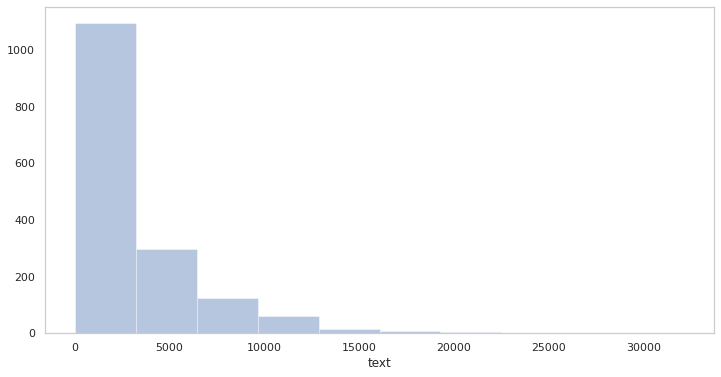

In [ ]:
seaborn.set(rc={'figure.figsize':(12, 6)})
seaborn.set_style("whitegrid", {'axes.grid' : False})
hist = seaborn.distplot(texts_length, kde=False, bins=10)

2. Aplique os seguintes passos de pré-processamento aos textos:

* Remova todas as palavras que contêm números;
* Converta as palavras para minúsculas;
* Remova pontuação;
* Tokenize os textos em palavras, gerando um dicionário único com $n$
tokens e convertendo cada texto em um vetor de dimensão $n$ com a respectiva contagem de palavras.

Em seguida, encontre as palavras mais frequentes.

In [ ]:
def preprocess(text):
  text = re.sub(r'\w*\d\w*', '', text) # remove todas as palavras que contém números
  text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ ]', '', text.lower()) # remove pontuação e converte para minúscula
  return re.sub(r'\s+', ' ', text) # remove espaços repetidos

In [ ]:
dataset.text = dataset.text.apply(preprocess)

In [ ]:
dataset['tokens'] = dataset.text.apply(lambda t: nltk.word_tokenize(t, language='portuguese'))
token_set = sorted(set([token for token_list in dataset.tokens.values for token in token_list]))
token_to_index = {token: i for i, token in enumerate(token_set)}
corpus_matrix = numpy.zeros(shape=(dataset.shape[0], len(token_to_index)))

for i, row in dataset.iterrows():
  for token in row.tokens:
    corpus_matrix[i][token_to_index[token]] += 1

most_freq = numpy.argmax(corpus_matrix, axis=1)

Palavra mais frequente em cada texto:


In [ ]:
dataset['mf_word'] = [token_set[i] for i in most_freq]
pandas.set_option('display.max_colwidth', 150)
dataset[['title', 'mf_word']]

,title,mf_word
0,"Coronavírus: pandemia pode jogar até 14 milhões de brasileiros na pobreza, diz estudo - BBC News Brasil",de
1,Coronavírus: como funcionam as duas vacinas contra covid-19 que serão testadas em brasileiros - BBC News Brasil,de
2,Coronavírus: Brasil passa o Reino Unido e se torna segundo país com mais mortes por covid-19 - BBC News Brasil,de
3,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil",de
4,"2ª onda do coronavírus? Irã vê aumento acelerado após reabertura, mas cita testes como causa - BBC News Brasil",de
...,...,...
1611,Farmácias têm falta de máscaras após confirmação de coronavírus no Brasil,de
1612,Ibovespa tem nova queda com mercado ainda preocupado com coronavírus,o
1613,Japonesa testa positivo pela segunda vez para coronavírus,de
1614,"Primeiro brasileiro com coronavírus tem sintomas brandos, mas continua isolado",de


3. Aplique os seguintes passos de pré-processamento aos textos processados na questão anterior:

* Remova stopwords;
* Realize rotulação de POS;
* Realize stemização;

Exiba os resultados em alguns textos. Verifique quais são as palavras mais frequentes e compare com as palavras mais frequentes da questão anterior.

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

In [ ]:
dataset.tokens = dataset.tokens.apply(lambda y: [stemmer.stem(d) for d in filter(lambda x: x not in stopwords, y)])
token_set = sorted(set([token for token_list in dataset.tokens.values for token in token_list]))
token_to_index = {token: i for i, token in enumerate(token_set)}
corpus_matrix = numpy.zeros(shape=(dataset.shape[0], len(token_to_index)))

for i, row in dataset.iterrows():
  for token in row.tokens:
    corpus_matrix[i][token_to_index[token]] += 1

most_freq = numpy.argmax(corpus_matrix, axis=1)

Treinando o modelo de _POS tagging_ para palavras em português. Código original em:

> https://github.com/fmaruki/Nltk-Tagger-Portuguese

In [ ]:
nltk.download('floresta')

[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Package floresta is already up-to-date!


True

In [ ]:
nltk.download('mac_morpho')

[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


True

In [ ]:
def convert_to_universal_tag(t, reverse=False):
    tagdict = {
        'n': "NOUN",
        'num': "NUM",
        'v-fin': "VERB",
        'v-inf': "VERB",
        'v-ger': "VERB",
        'v-pcp': "VERB",
        'pron-det': "PRON",
        'pron-indp': "PRON",
        'pron-pers': "PRON",
        'art': "DET",
        'adv': "ADV",
        'conj-s': "CONJ",
        'conj-c': "CONJ",
        'conj-p': "CONJ",
        'adj': "ADJ",
        'ec': "PRT",
        'pp': "ADP",
        'prp': "ADP",
        'prop': "NOUN",
        'pro-ks-rel': "PRON",
        'proadj': "PRON",
        'prep': "ADP",
        'nprop': "NOUN",
        'vaux': "VERB",
        'propess': "PRON",
        'v': "VERB",
        'vp': "VERB",
        'in': "X",
        'prp-': "ADP",
        'adv-ks': "ADV",
        'dad': "NUM",
        'prosub': "PRON",
        'tel': "NUM",
        'ap': "NUM",
        'est': "NOUN",
        'cur': "X",
        'pcp': "VERB",
        'pro-ks': "PRON",
        'hor': "NUM",
        'pden': "ADV",
        'dat': "NUM",
        'kc': "ADP",
        'ks': "ADP",
        'adv-ks-rel': "ADV",
        'npro': "NOUN",
    }
    if t in ["N|AP","N|DAD","N|DAT","N|HOR","N|TEL"]:
        t = "NUM"
    if reverse:
        if "|" in t: t = t.split("|")[0]
    else:
        if "+" in t: t = t.split("+")[1]
        if "|" in t: t = t.split("|")[1]
        if "#" in t: t = t.split("#")[0]
    t = t.lower()
    return tagdict.get(t, "." if all(tt in punctuation for tt in t) else t)

dataset1 = list(nltk.corpus.floresta.tagged_sents())
dataset2 = [[w[0] for w in sent] for sent in nltk.corpus.mac_morpho.tagged_paras()]

traindata = [[(w, convert_to_universal_tag(t)) for (w, t) in sent] for sent in dataset1]
traindata2 = traindata + [[(w, convert_to_universal_tag(t, reverse=True)) for (w, t) in sent] for sent in dataset2]

shuffle(traindata)
shuffle(traindata2)

regex_patterns = [
    (r"^[nN][ao]s?$", "ADP"),
    (r"^[dD][ao]s?$", "ADP"),
    (r"^[pP]el[ao]s?$", "ADP"),
    (r"^[nN]est[ae]s?$", "ADP"),
    (r"^[nN]um$", "ADP"),
    (r"^[nN]ess[ae]s?$", "ADP"),
    (r"^[nN]aquel[ae]s?$", "ADP"),
    (r"^\xe0$", "ADP"),
]

tagger = nltk.BigramTagger(
            traindata, backoff=nltk.RegexpTagger(
                regex_patterns, backoff=nltk.UnigramTagger(
                    traindata2, backoff=nltk.AffixTagger(
                        traindata2, backoff=nltk.DefaultTagger('NOUN')
                    )
                )
            )
        )
templates = nltk.brill.fntbl37()
tagger = nltk.BrillTaggerTrainer(tagger, templates)
tagger = tagger.train(traindata, max_rules=100)

In [ ]:
dataset['pos'] = dataset.text.apply(lambda text: tagger.tag(nltk.word_tokenize(text)))

In [ ]:
dataset.pos

0       [(a, DET), (turbulência, NOUN), (econômica, ADJ), (causada, VERB), (pela, ADP), (pandemia, NOUN), (do, ADP), (novo, ADJ), (coronavírus, NOUN), (po...
1       [(cerca, ADP), (de, ADP), (mil, NUM), (voluntários, NOUN), (brasileiros, ADJ), (vão, VERB), (receber, VERB), (nas, PRON), (próximas, ADJ), (semana...
2       [(atualizada, VERB), (s, PRON), (de, ADP), (de, ADP), (junho, NOUN), (de, ADP), (o, DET), (brasil, NOUN), (totalizou, VERB), (nesta, ADP), (sextaf...
3       [(quando, ADV), (em, ADP), (de, ADP), (março, NOUN), (o, DET), (governo, NOUN), (indiano, ADJ), (iniciou, VERB), (um, DET), (estrito, NOUN), (isol...
4       [(o, DET), (irã, NOUN), (registrou, VERB), (um, DET), (rápido, ADJ), (aumento, NOUN), (no, ADP), (número, NOUN), (de, ADP), (casos, NOUN), (de, AD...
                                                                                ...                                                                          
1611    [(com, ADP), (a, DET), (confirmação, NOUN), 

Palavra mais frequente em cada texto:


In [ ]:
dataset['mf_word'] = [token_set[i] for i in most_freq]
dataset[['title', 'mf_word']]

,title,mf_word
0,"Coronavírus: pandemia pode jogar até 14 milhões de brasileiros na pobreza, diz estudo - BBC News Brasil",pobr
1,Coronavírus: como funcionam as duas vacinas contra covid-19 que serão testadas em brasileiros - BBC News Brasil,vacin
2,Coronavírus: Brasil passa o Reino Unido e se torna segundo país com mais mortes por covid-19 - BBC News Brasil,dad
3,"Coronavírus na Índia: com lockdown 'insustentável', Índia reabre em meio a disparada de casos e temores de 'bomba-relógio' - BBC News Brasil",cas
4,"2ª onda do coronavírus? Irã vê aumento acelerado após reabertura, mas cita testes como causa - BBC News Brasil",irã
...,...,...
1611,Farmácias têm falta de máscaras após confirmação de coronavírus no Brasil,másc
1612,Ibovespa tem nova queda com mercado ainda preocupado com coronavírus,econom
1613,Japonesa testa positivo pela segunda vez para coronavírus,pesso
1614,"Primeiro brasileiro com coronavírus tem sintomas brandos, mas continua isolado",brasil
